This Notebook will provide an example for the moetabolic modeling of "Trans 4 Hydroxy L proline" production in the e coli core model.

For modeling and FBA we will use the "COBRApy" (**CO**nstrained **B**ased **R**econstruction and **A**nalysis for **py**thon).
Install it via 

*pip3 install cobra*

and import:

In [1]:
import cobra

*cobrapy* includes a function to directly load online models, e.g. from the [bigg database](http://bigg.ucsd.edu/).

We will use the rather smal *E. coli* core model "e_coli_core".<br>
Since this model lacks some relevant reactions of proline metabolism we will get them from a full genome scale reconstruction.<br>
"iML1515" is such a GEM for the K12 strain.

In [2]:
# Load the E. coli core model from BiGG
core_model = cobra.io.load_model("e_coli_core")

# Load the E. coli K-12 model from BiGG
k12_model = cobra.io.load_model("iML1515")

print("Core model reactions:", len(core_model.reactions))
print("K-12 model reactions:", len(k12_model.reactions))

Core model reactions: 95
K-12 model reactions: 2712


As you can see when we print the lengths of the models reactions list, the core model is significantly smaller than the the K12 model.<br>
This allows us to analyze the model in depth.

We will now populate the core model with missing metabolites and reactions from the K12 model.
Proline is added, both in the external medium as well as in the cytosol.
Then a transport reaction is created that moves external proline into the cytosol.
This reaction is added to the core model together with a boundary reaction for proline that creates external proline inside the model and two reactions catalyzed by the enzyme encoded by the b1014 gene.

In [3]:
core_model.add_metabolites([
    k12_model.metabolites.pro__L_c,
    k12_model.metabolites.pro__L_e
])
PROt2r = cobra.Reaction(
    "PROt2r",
    name="Proline Transport"
)
PROt2r.add_metabolites({
    k12_model.metabolites.pro__L_c: 1,
    k12_model.metabolites.pro__L_e: -1
})
core_model.add_reactions([
    k12_model.reactions.EX_pro__L_e,
    PROt2r,
    k12_model.reactions.PROD3,
    k12_model.reactions.P5CD,
])

core_model.reactions.EX_pro__L_e.lower_bound = -10.0
core_model.reactions.EX_pro__L_e.upper_bound = -10.0

Now we want to see how proline in the medium affects growth of the model.<br>
For visualization matplotlib is imported.
An array is generated for 100 datapoints from 0 to 20 mmol/gDW/h proline import.
Upper and lower bound of the boundary reaction is set to the same value, enforcing uptake at this rate.
Then the model is optimized for growth by setting the biomass reaction as objective.

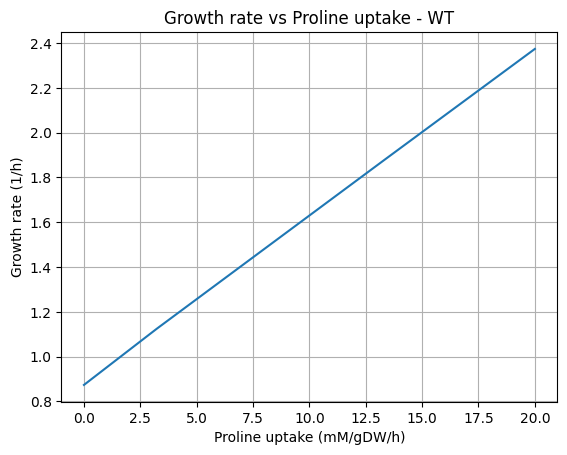

In [4]:

# make plot of growth rate dependent on proline concentration
import matplotlib.pyplot as plt
import numpy as np

# use a context manager to revert changes after the simulation:
with core_model:
    core_model.reactions.EX_pro__L_e.bounds = (0, 0)  # Set bounds to zero to avoid initial growth
    core_model.objective = "BIOMASS_Ecoli_core_w_GAM"
    proline_fluxes = np.linspace(0, 20, 100)
    growth_rates = []

    for conc in proline_fluxes:
        core_model.reactions.EX_pro__L_e.bounds = (-conc, -conc)
        growth_rate = core_model.optimize().objective_value
        growth_rates.append(growth_rate)

plt.plot(proline_fluxes, growth_rates)
plt.xlabel("Proline uptake (mM/gDW/h)")
plt.ylabel("Growth rate (1/h)")
plt.title("Growth rate vs Proline uptake - WT")
plt.grid()
plt.show()    

The growth rate increases lineally with more provided proline.

Now the wet-lab experiment is recreated.<br>
We make a new "mutant" model as a copy of the modified core model and knock out the b1014 (*putA*) gene.<br>
The "L-proline trans-4-hydroxylase" reaction is created as well as the "Trans 4 Hydroxy L proline" metabolite.
The stoichiometry of the reaction is introduced with a dict.<br>
We add the reaction to the mutant model and test with a simulation. <br>
The summary shows that imported proline is converted to hydroxyproline.

In [5]:
mutant = core_model.copy()
mutant.genes.b1014.knock_out()
pro4hyd = cobra.Reaction(
    "PRO4HDC",
    name="L-proline trans-4-hydroxylase"
)

new4hpro_LT = cobra.Metabolite(
    "4hpro_LT_c",
    name="Trans 4 Hydroxy L proline",
    compartment="c",
    formula="C5H9NO3"
)
pro4hyd.add_metabolites({
    core_model.metabolites.pro__L_c: -1.0,
    core_model.metabolites.akg_c: -1.0,
    core_model.metabolites.o2_c: -1.0,
    core_model.metabolites.succ_c: 1.0,
    k12_model.metabolites.co2_c: 1.0,
    new4hpro_LT: 1.0
})
mutant.add_reactions([pro4hyd])
mutant.add_boundary(new4hpro_LT, type="demand")

solpcore = cobra.flux_analysis.parsimonious.pfba(mutant)
print(mutant.summary(solution=solpcore))
# for rxn in solpcore.fluxes.index:
#     if abs(solpcore.fluxes[rxn]) > 1e-13:
#         print(mutant.reactions.get_by_id(rxn), solpcore.fluxes[rxn])

Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.6579596670724083

Uptake
------
Metabolite    Reaction  Flux  C-Number C-Flux
  glc__D_e EX_glc__D_e    10         6 54.55%
     nh4_e    EX_nh4_e 3.588         0  0.00%
      o2_e     EX_o2_e 29.71         0  0.00%
      pi_e     EX_pi_e  2.42         0  0.00%
  pro__L_e EX_pro__L_e    10         5 45.45%

Secretion
---------
Metabolite      Reaction   Flux  C-Number C-Flux
4hpro_LT_c DM_4hpro_LT_c    -10         5 60.98%
     co2_e      EX_co2_e -18.94         1 23.10%
     for_e      EX_for_e -13.06         1 15.92%
     h2o_e      EX_h2o_e -23.73         0  0.00%
       h_e        EX_h_e -26.26         0  0.00%



Now we redo the plot from before but with the mutant model.

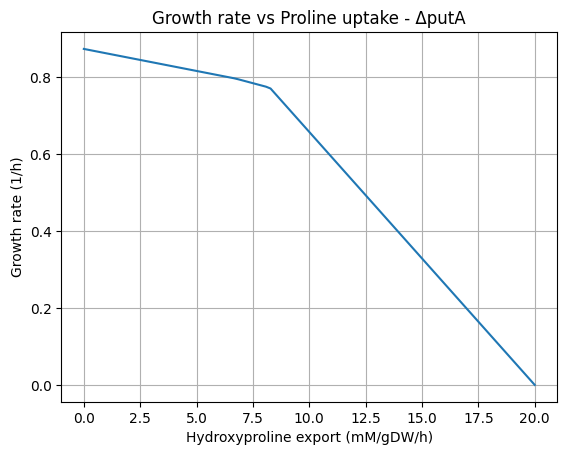

In [6]:
# make plot of growth rate dependent on proline concentration

with mutant:
    mutant.reactions.EX_pro__L_e.bounds = (0, 0)  # Set bounds to zero to avoid initial growth
    mutant.objective = "BIOMASS_Ecoli_core_w_GAM"
    proline_fluxes = np.linspace(0, 20, 100)
    growth_rates = []
    hydpro_fluxes = []
    fvas = {rxn.id: [] for rxn in mutant.reactions}

    for conc in proline_fluxes:
        mutant.reactions.EX_pro__L_e.bounds = (-conc, -conc)
        sol = cobra.flux_analysis.parsimonious.pfba(mutant)
        growth_rate = sol.fluxes.get("BIOMASS_Ecoli_core_w_GAM", 0)
        hydpro_flux = sol.fluxes.get("DM_4hpro_LT_c", 0)
        growth_rates.append(growth_rate)
        hydpro_fluxes.append(hydpro_flux)
        fva = cobra.flux_analysis.flux_variability_analysis(mutant)
        for rxn in mutant.reactions:
            fvas[rxn.id].append((fva.at[rxn.id, "minimum"], fva.at[rxn.id, "maximum"]))
fig, ax = plt.subplots()
ax.plot(hydpro_fluxes, growth_rates, label="Growth rate")
ax.set_xlabel("Hydroxyproline export (mM/gDW/h)")
ax.set_ylabel("Growth rate (1/h)")
plt.title("Growth rate vs Proline uptake - ΔputA")
plt.grid()
plt.show()

The growth behavior has drastically changed:
Since proline cannot be used in metabolism and the conversion to hydroxyproline takes up cellular resources, the growth rate declines.

The advantage of simulating with a smaller model is the ability to analyze the simulation result in depth.<br>
We can use Flux Variability Analysis (FVA) to identify which reactions are most affected by the flux shift in metabolism.<br>
 

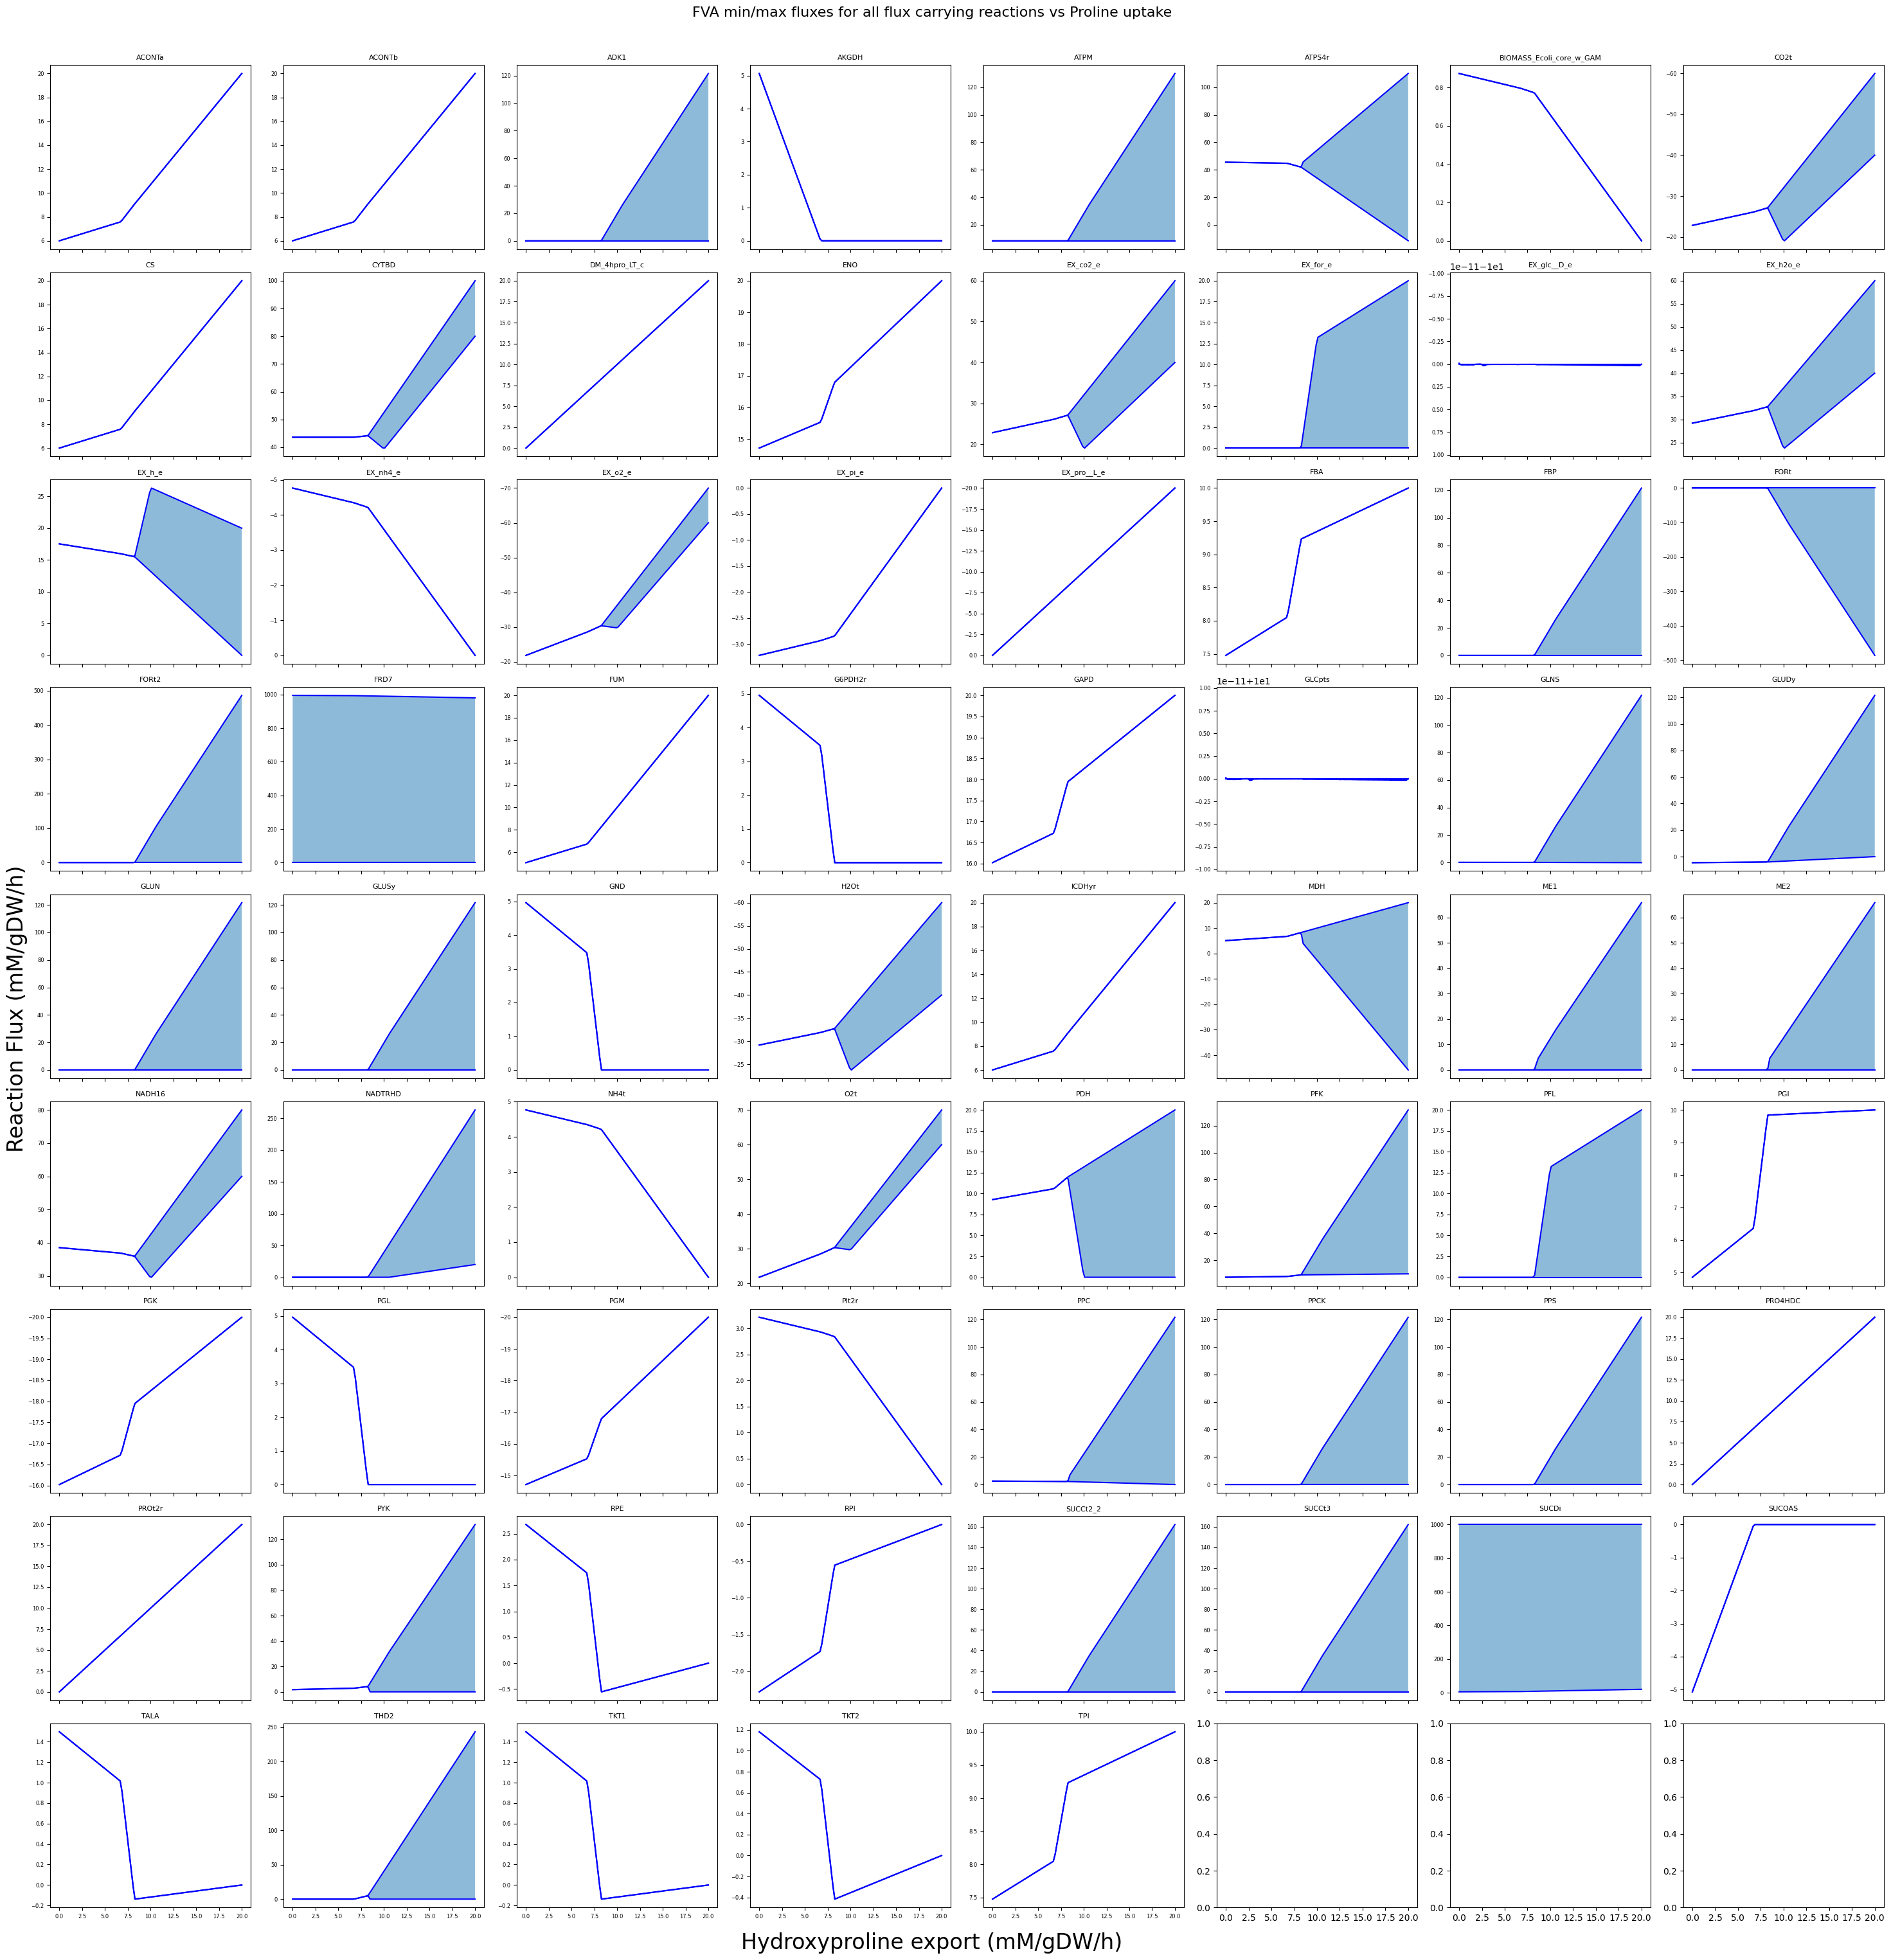

In [7]:
# Plotting: 10x10 grid (100 reactions)
fig, axes = plt.subplots(9, 8, figsize=(30, 30), sharex=True)
axes = axes.flatten()
for rxn in fvas.copy():
    if all([all([abs(t[0]) < 1e-10 for t in fvas[rxn]]), all([abs(t[1]) < 1e-10 for t in fvas[rxn]])]):
        del fvas[rxn]
reaction_ids = sorted(list(fvas.keys()))
# reaction_ids.remove("DM_4hpro_LT_c")  # Remove biomass reaction from plotting

for idx, rxn in enumerate(reaction_ids[:100]):  # Only first 100 reactions
    ax = axes[idx]
    ax.fill_between(proline_fluxes, [t[0] for t in fvas[rxn]], [t[1] for t in fvas[rxn]], alpha=0.5)
    ax.plot(hydpro_fluxes, [t[0] for t in fvas[rxn]], color='blue', label='Min Flux')
    ax.plot(hydpro_fluxes, [t[1] for t in fvas[rxn]], color='blue', label='Max Flux')
    if all([i <= 0 for i in list(sum(fvas[rxn], ()))]): #reverse y-axis for imports
        ax.yaxis.set_inverted(True)
    ax.set_title(rxn, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    # if idx % 8 == 0:
    #     ax.set_ylabel("Flux")
    # if idx // 8 == 8:
    #     ax.set_xlabel("Proline uptake (mM/gDW/h)")
# Add one big x and y label for the whole figure
fig.supylabel("Reaction Flux (mM/gDW/h)", fontsize=24)
fig.supxlabel("Hydroxyproline export (mM/gDW/h)", fontsize=24)

plt.tight_layout(rect=[0.01, 0.005, 1, 1])  # Adjust layout to make room for the big labels
plt.suptitle("FVA min/max fluxes for all flux carrying reactions vs Proline uptake", y=1.02, fontsize=16)
plt.show()

Finally the modified model is exportet for further analysis with escher fba.

In [8]:
cobra.io.save_json_model(mutant, "mutant_model.json")

To simulate FBA of this model visually in a web browser go to [Escher-FBA](https://sbrg.github.io/escher-fba/#/).<br>
After Launching Escher-FBA, got to Map - load map JSON (ctrl + O) and upload the "Map_Ecoli_hydroprol.json" file.<br>
Then got to Model - load COBRA model JSON (ctrl + M) and upload the model file "mutant_model.json"<br>
Now you can for example change the proline influx and see how the flux composition in the network changes.